<a href="https://colab.research.google.com/github/fredyvelasquezgt/Lab-9-DL/blob/main/lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 9 - Deep Learning

Autores

- Angel Higueros 20460
- Fredy Velasquez 2010111

### Task 1 - Práctica

1. Preparacion de datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [4]:
data_path = "/content/train.csv"

data = pd.read_csv(data_path)

In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 34.8 MB


In [32]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,0.226192
std,2.872283,14.430878,0.124680
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,0.129870
50%,5.500000,25.500000,0.203463
75%,8.000000,38.000000,0.303030
max,10.000000,50.000000,1.000000


In [34]:
data.corr()


<ipython-input-34-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,store,item,sales
store,1.000000e+00,-6.774332e-19,-0.008170
item,-6.774332e-19,1.000000e+00,-0.055998
sales,-8.170361e-03,-5.599807e-02,1.000000


In [5]:
# Verificando valores nulos
print(data.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


In [6]:
# Convertir la columna 'date' a datetime
data['date'] = pd.to_datetime(data['date'])

# Escalado de la columna 'sales'
scaler = MinMaxScaler(feature_range=(0, 1))
data['sales'] = scaler.fit_transform(data[['sales']])

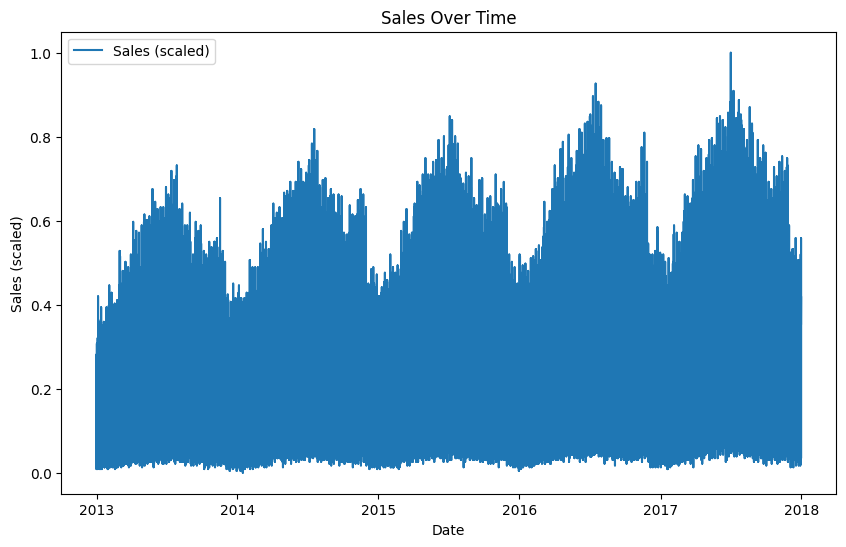

In [7]:
import matplotlib.pyplot as plt

# Asegúrate de que tus datos estén ordenados por fecha si no lo están ya
data = data.sort_values('date')

# Crear un gráfico de líneas de ventas a lo largo del tiempo
plt.figure(figsize=(10,6))  # cambiar el tamaño del gráfico según sea necesario
plt.plot(data['date'], data['sales'], label='Sales (scaled)')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales (scaled)')
plt.legend()
plt.show()


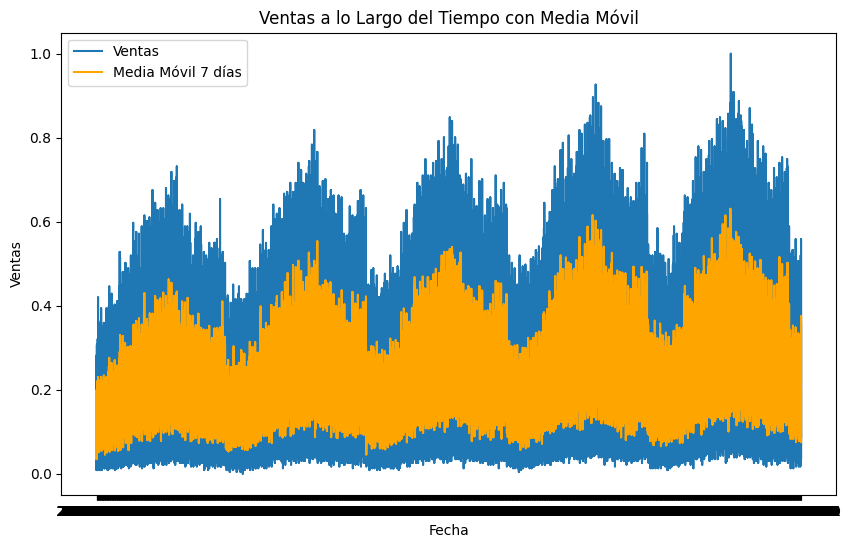

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de que tus datos estén ordenados por fecha si no lo están ya
data = data.sort_values('date')

# Calcula el promedio móvil
data['rolling_mean'] = data['sales'].rolling(window=7).mean()  # ventana de 7 días

plt.figure(figsize=(10,6))
plt.plot(data['date'], data['sales'], label='Ventas')
plt.plot(data['date'], data['rolling_mean'], label='Media Móvil 7 días', color='orange')
plt.title('Ventas a lo Largo del Tiempo con Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


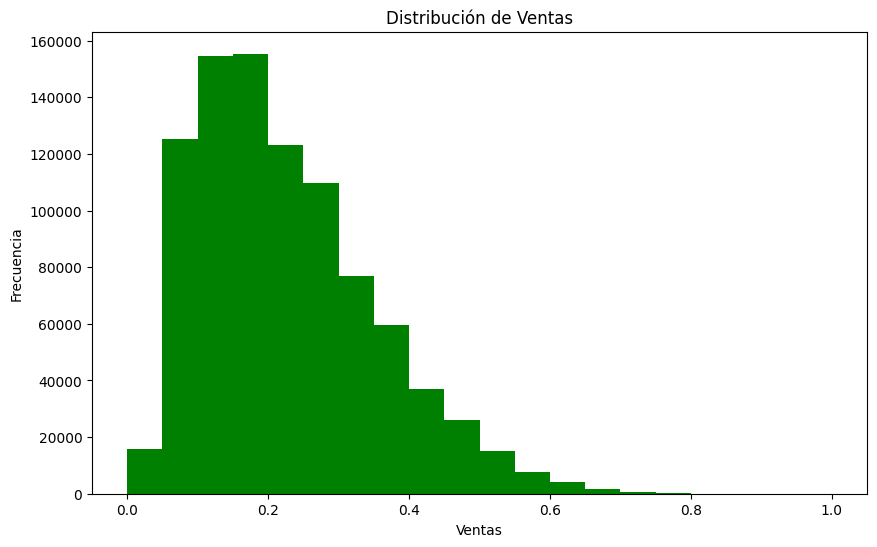

In [37]:
plt.figure(figsize=(10,6))
plt.hist(data['sales'], bins=20, color='green')
plt.title('Distribución de Ventas')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()


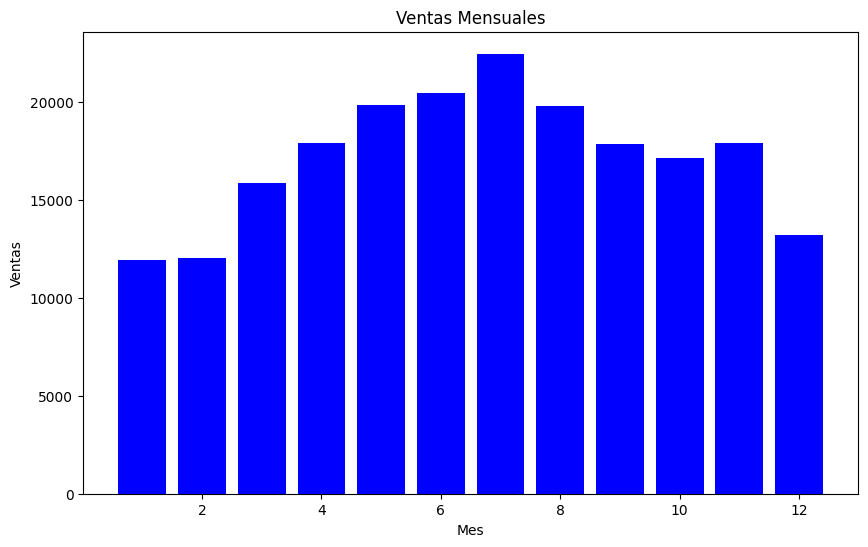

In [38]:
# Extrae el mes y luego agrupa las ventas por mes
data['month'] = pd.to_datetime(data['date']).dt.month  # extrae el mes
monthly_sales = data.groupby('month')['sales'].sum().reset_index()

plt.figure(figsize=(10,6))
plt.bar(monthly_sales['month'], monthly_sales['sales'], color='blue')
plt.title('Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.show()


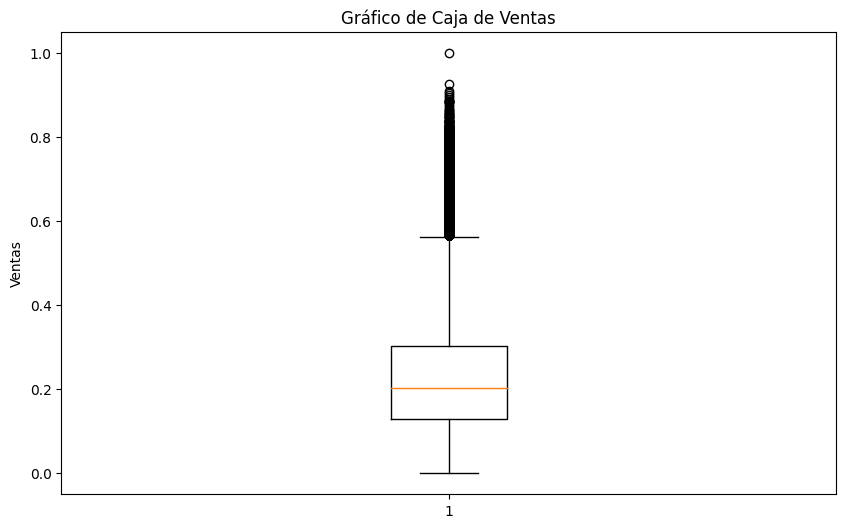

In [39]:
plt.figure(figsize=(10,6))
plt.boxplot(data['sales'])
plt.title('Gráfico de Caja de Ventas')
plt.ylabel('Ventas')
plt.show()


2. Preparacion de datos

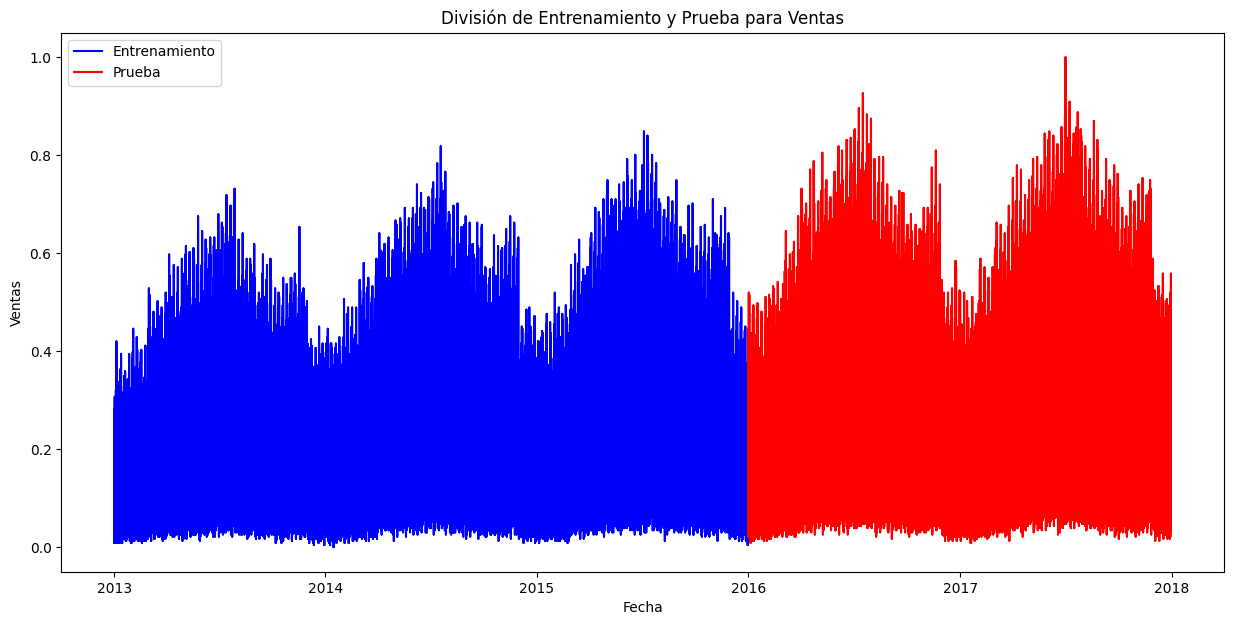

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que 'data' es tu DataFrame y ya has realizado la limpieza y escalado necesario.
# Además, asegúrate de que 'date' es una columna datetime si aún no lo es.
data['date'] = pd.to_datetime(data['date'])

# División de datos en entrenamiento y prueba basada en la fecha.
train_data = data[data['date'] < '2016-01-01']
test_data = data[data['date'] >= '2016-01-01']

# Crear figuras y ejes
fig, ax = plt.subplots(figsize=(15,7))

# Gráfico para datos de entrenamiento
ax.plot(train_data['date'], train_data['sales'], label='Entrenamiento', color='blue')

# Gráfico para datos de prueba
ax.plot(test_data['date'], test_data['sales'], label='Prueba', color='red')

# Etiquetas y leyenda
ax.set_title('División de Entrenamiento y Prueba para Ventas')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas')
ax.legend()

plt.show()



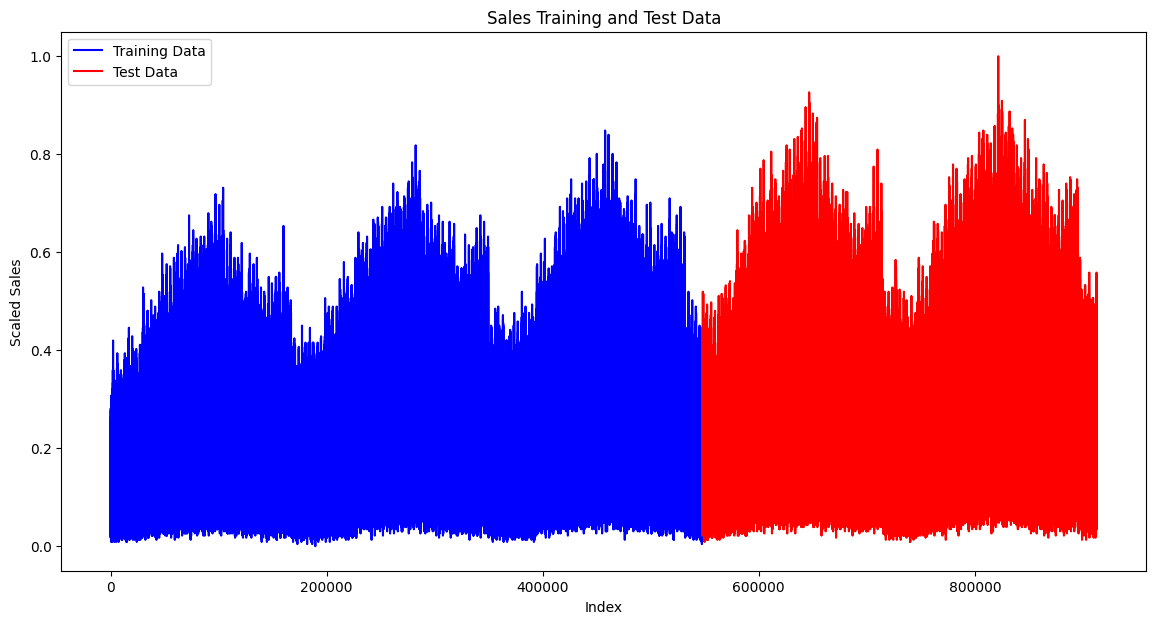

In [10]:
import matplotlib.pyplot as plt

# Crear índices para el eje x, que son simplemente números enteros secuenciales
train_index = range(len(train_data))
test_index = range(len(train_data), len(train_data) + len(test_data))

plt.figure(figsize=(14,7))

# Graficar datos de entrenamiento
plt.plot(train_index, train_data, label='Training Data', color='blue')

# Graficar datos de prueba
plt.plot(test_index, test_data, label='Test Data', color='red')

plt.title('Sales Training and Test Data')
plt.xlabel('Index')
plt.ylabel('Scaled Sales')
plt.legend()
plt.show()


In [16]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [17]:
window_size = 60  # Por ejemplo, usar los 60 puntos de datos anteriores para predecir el siguiente

# Crear secuencias para entrenamiento
X_train, y_train = create_sequences(train_data, window_size)

# Crear secuencias para prueba
X_test, y_test = create_sequences(test_data, window_size)

# Es importante que los datos estén en la forma correcta para alimentar a la LSTM
# Reshape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Dividir los datos de entrenamiento para crear un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


3. Seleccion de modelo

- Se usara LSTM con cinco capas principales: dos capas LSTM, dos capas Dropout y una capa Dense al final. Las capas LSTM y Dense son las que realizan la mayor parte del procesamiento y aprendizaje, mientras que las capas Dropout ayudan a prevenir el sobreajuste durante el entrenamiento

4. Arquitectura del modelo

In [18]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Salida de una unidad para la predicción de ventas

model.compile(optimizer='adam', loss='mean_squared_error')


5. Entrenamiento del modelo

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
13686/13686 [==============================] - 414s 30ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/50
13686/13686 [==============================] - 406s 30ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 3/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
13686/13686 [==============================] - 403s 29ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/50
13686/13686 [==============================] - 404s 29ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/50
13686/13686 [==============================] - 404s 29ms/step - loss: 0.0013 - val_loss: 9.8134e-04
Epoch 8/50
13686/13686 [==============================] - 403s 29ms/step - loss: 0.0013 - val_loss: 9.8694e-04
Epoch 9/50
13686/13686 [==============================] - 404s 30ms/step - loss: 0.0013 - val_loss: 9.9559e-04
Epoch 10/50
13686/13686 [

In [19]:
model.save('my_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo
new_model = load_model('my_model.keras')

In [ ]:
# Evaluar el modelo con datos de prueba
loss = new_model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

11420/11420 [==============================] - 117s 10ms/step - loss: 0.0014
Loss: 0.001352919964119792


In [ ]:
predicted_sales = new_model.predict(X_test)

11420/11420 [==============================] - 116s 10ms/step


In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Realizar predicciones en el conjunto de test
predictions = new_model.predict(X_test)


# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # La raíz cuadrada del MSE es el RMSE

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


11420/11420 [==============================] - 118s 10ms/step
MAE: 0.028124939863277777
MSE: 0.0013529171084681877
RMSE: 0.03678202153862927


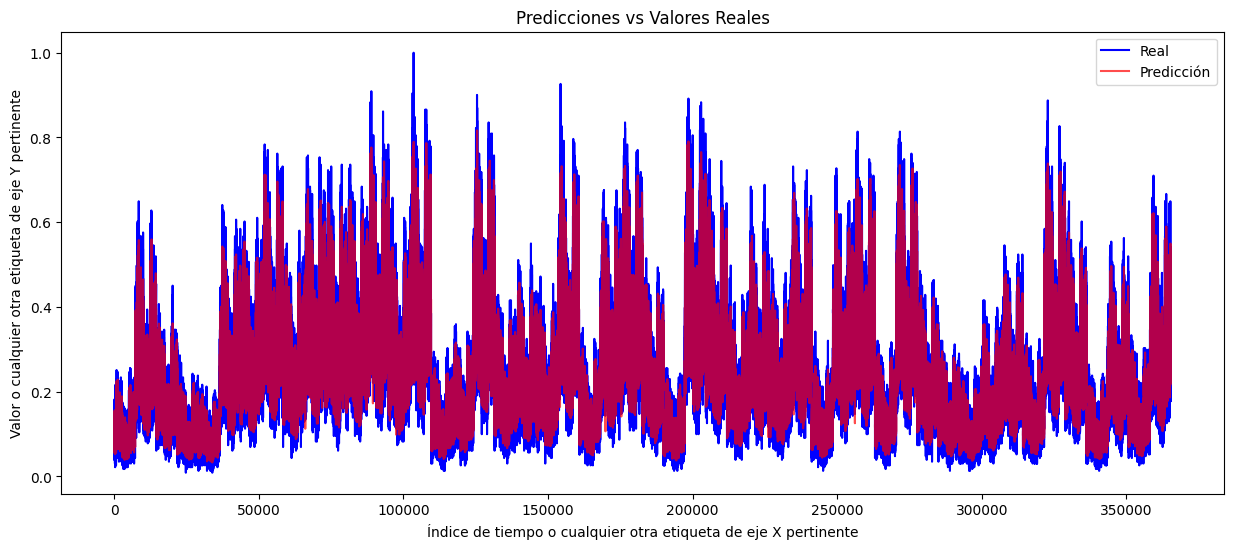

In [ ]:
# Crear una figura y un set de subplots
plt.figure(figsize=(15,6))

# Dibujar los valores reales
plt.plot(y_test, color='blue', label='Real')

# Dibujar las predicciones
plt.plot(predictions, color='red', alpha=0.7, label='Predicción')

# Títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de tiempo o cualquier otra etiqueta de eje X pertinente')
plt.ylabel('Valor o cualquier otra etiqueta de eje Y pertinente')
plt.legend()  # Muestra la leyenda

# Mostrar la gráfica
plt.show()

7. Ajuste de hiperparámetros


Cambios realizados:

*   BatchNormalization: Se aplicó normalización por lotes al inicio para facilitar el aprendizaje rápido y estable.
*   Unidades y capas LSTM: Se aumentaron las unidades en la primera capa LSTM a 100 y se usaron un total de tres capas LSTM para capturar relaciones temporales más complejas.
*   Dropout: Se implementó un 50% de dropout después de cada capa LSTM para combatir el sobreajuste.
*   Optimizador: Se usó Adam con una tasa de aprendizaje de 0.001, que es un equilibrio entre la velocidad de entrenamiento y la capacidad de convergencia.
*   Entrenamiento: Se entrenó el modelo durante 40 épocas con un tamaño de lote de 64. Estos números afectan cómo de rápido y qué tan bien el modelo puede aprender.
*   Evaluación y Visualización: Se calculó MAE, MSE, y RMSE para evaluar el rendimiento, y luego se trazaron las predicciones en comparación con los valores reales para visualizar qué tan bien el modelo está prediciendo los datos.








Epoch 1/20
6843/6843 [==============================] - 1043s 152ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 2/20
6843/6843 [==============================] - 1035s 151ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/20
6843/6843 [==============================] - 1092s 160ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/20
6843/6843 [==============================] - 1039s 152ms/step - loss: 0.0018 - val_loss: 9.8741e-04
Epoch 5/20
6843/6843 [==============================] - 1038s 152ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/20
6843/6843 [==============================] - 1096s 160ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/20
6843/6843 [==============================] - 1038s 152ms/step - loss: 0.0018 - val_loss: 9.7022e-04
Epoch 8/20
6843/6843 [==============================] - 1040s 152ms/step - loss: 0.0017 - val_loss: 9.8858e-04
Epoch 9/20
6843/6843 [==============================] - 1095s 160ms/step - loss: 0.0019 - val_loss: 9.9120e-04
Epoch 10/20
6843/6843

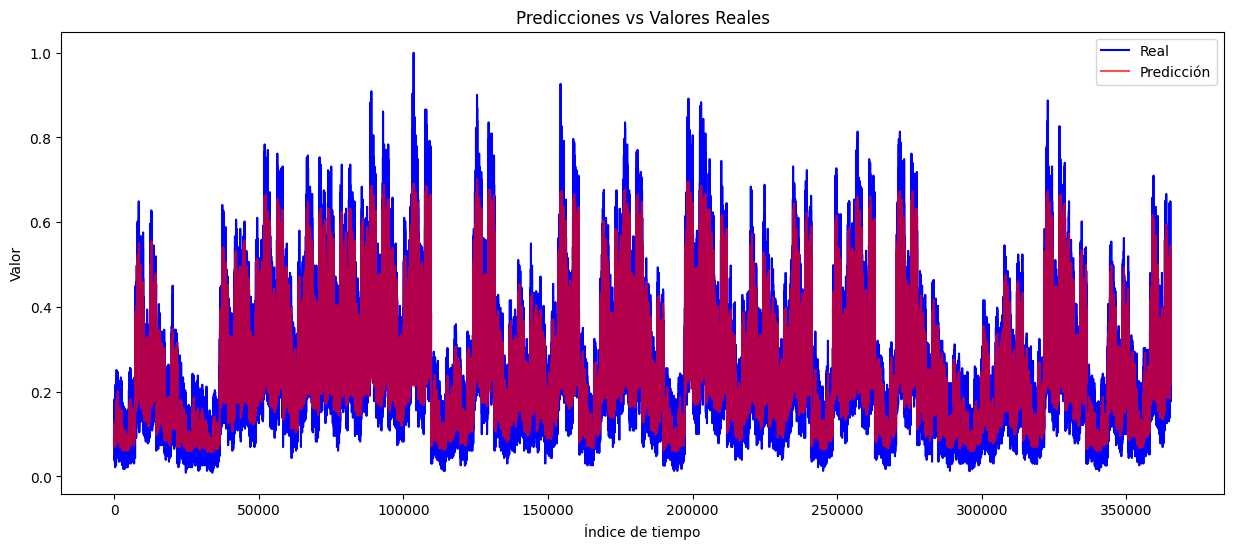

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Construcción del modelo
model = Sequential()

# Normalización por lotes antes de las capas LSTM
model.add(BatchNormalization(input_shape=(X_train.shape[1], 1)))

# Aumento en el número de unidades, adición de más capas LSTM y aumento del dropout
model.add(LSTM(units=100, return_sequences=True))  # Aumento a 100 unidades
model.add(Dropout(0.5))  # Aumento al 50%
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.5))  # Aumento al 50%
model.add(LSTM(units=50))
model.add(Dropout(0.5))  # Aumento al 50%

# Capa de salida
model.add(Dense(units=1))

# Compilación del modelo con una tasa de aprendizaje modificada
adam_optimizer = Adam(lr=0.001)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Entrenamiento del modelo con más épocas y un tamaño de lote diferente
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Realizar predicciones
predictions = model.predict(X_test)

# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # RMSE

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Crear una figura y un set de subplots
plt.figure(figsize=(15,6))

# Dibujar los valores reales
plt.plot(y_test, color='blue', label='Real')

# Dibujar las predicciones
plt.plot(predictions, color='red', alpha=0.7, label='Predicción')

# Títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()


8. Forescasting

In [21]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Función para crear secuencias
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
    return np.array(X)

# Cargar el modelo
model = load_model('my_model.keras')  # Ajusta esto a tu situación


In [25]:
window_size = 60
forecast_length = 90  # Para pronosticar 3 meses
results = pd.DataFrame()

# Limitamos el bucle a 2 tiendas, como se solicitó
for store in range(1, 3):
    store_data = data[data['store'] == store]

    # Sumamos las ventas de todos los artículos para la tienda actual
    store_sales = store_data.groupby(['date'])['sales'].sum().reset_index()

    # Usa los últimos datos para hacer las predicciones
    last_sequence = store_sales['sales'].values[-window_size:].reshape(1, window_size, 1)

    # Realizar las predicciones iterativamente y agregar cada predicción a la secuencia para las próximas
    forecasts = []
    for i in range(forecast_length):
        next_point = model.predict(last_sequence)
        forecasts.append(next_point[0][0])
        last_sequence = np.roll(last_sequence, shift=-1)
        last_sequence[0][-1][0] = next_point

    # Agregar las predicciones al dataframe de resultados
    forecast_dates = pd.date_range(start='2017-01-01', periods=forecast_length)
    for j, forecast_date in enumerate(forecast_dates):
        results = results.append({
            'store': store,
            # 'item': item,  # Ya no estamos prediciendo por artículo, así que esta línea no es necesaria
            'date': forecast_date.strftime('%Y-%m-%d'),
            'forecasted_sales': forecasts[j]
        }, ignore_index=True)

print(results)


1/1 [==============================] - 0s 39ms/step


<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-i

1/1 [==============================] - 0s 26ms/step
     store        date  forecasted_sales
0        1  2017-01-01      1.288945e-02
1        1  2017-01-02     -5.692728e-03
2        1  2017-01-03     -1.015301e-02
3        1  2017-01-04     -6.668569e-03
4        1  2017-01-05     -3.236644e-04
..     ...         ...               ...
175      2  2017-03-27     -7.538073e-07
176      2  2017-03-28     -6.295229e-07
177      2  2017-03-29     -5.238956e-07
178      2  2017-03-30     -4.344884e-07
179      2  2017-03-31     -3.590473e-07

[180 rows x 3 columns]


<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-25-20957b63df68>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-i

9. Visualización

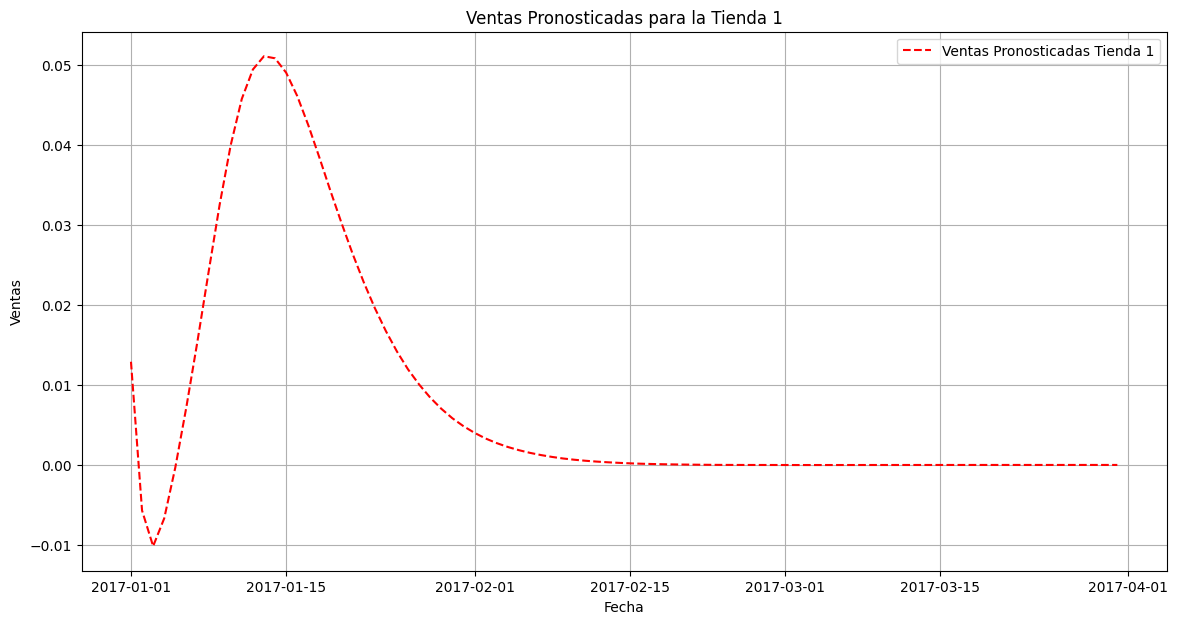

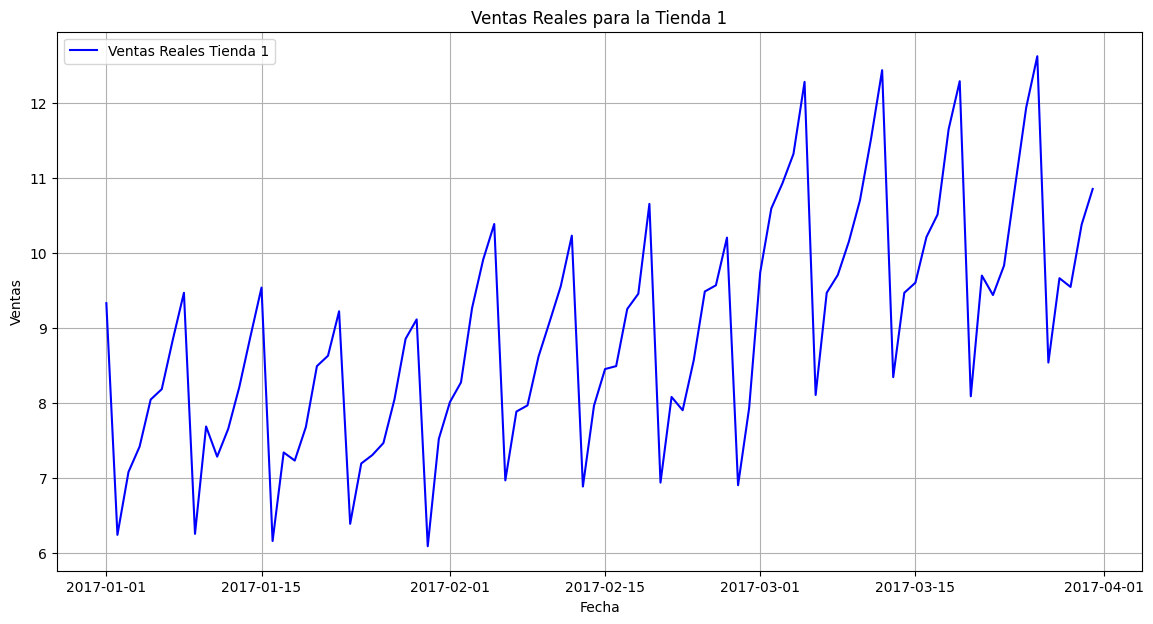


Métricas de error para la Tienda 1:
Mean Absolute Error (MAE): 8.95
Mean Squared Error (MSE): 82.47
Root Mean Squared Error (RMSE): 9.08


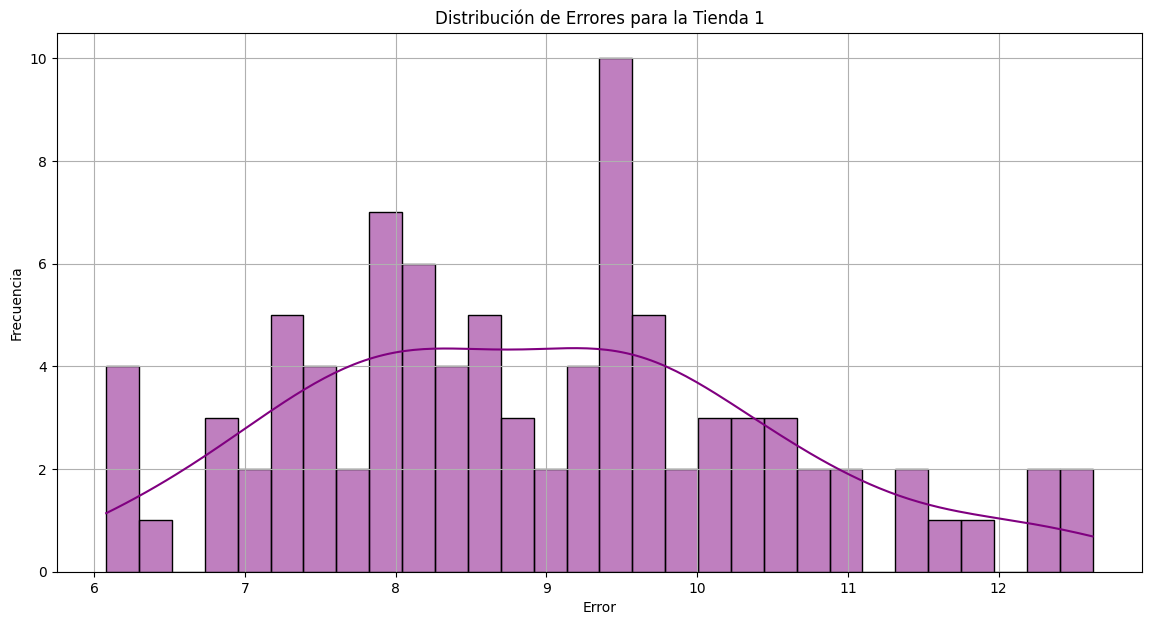

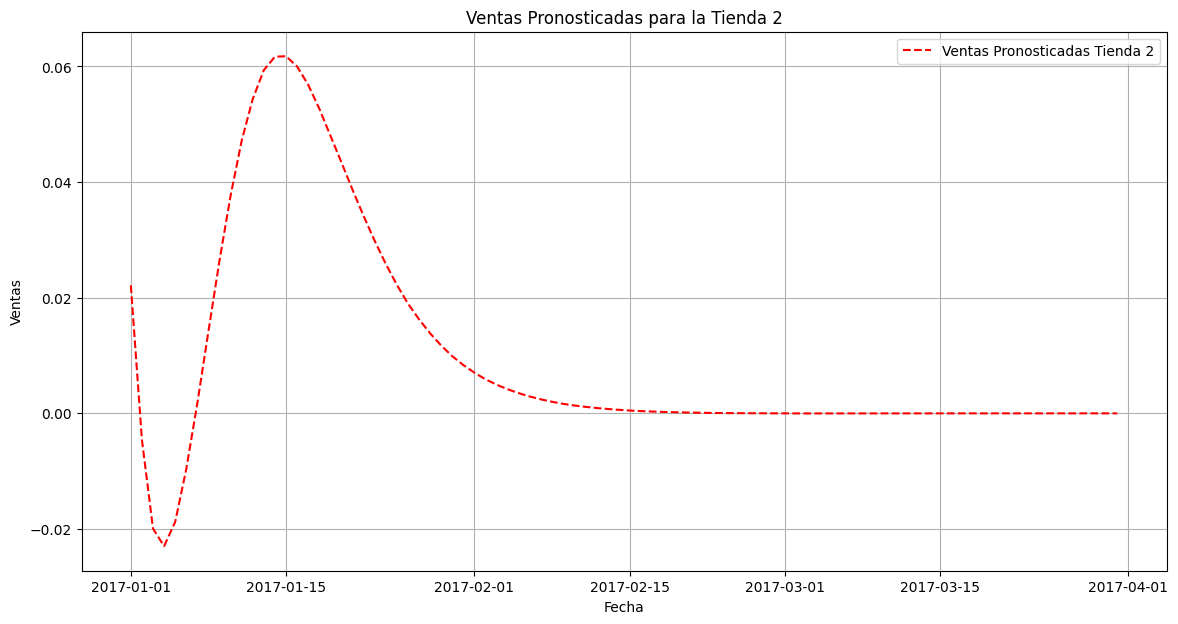

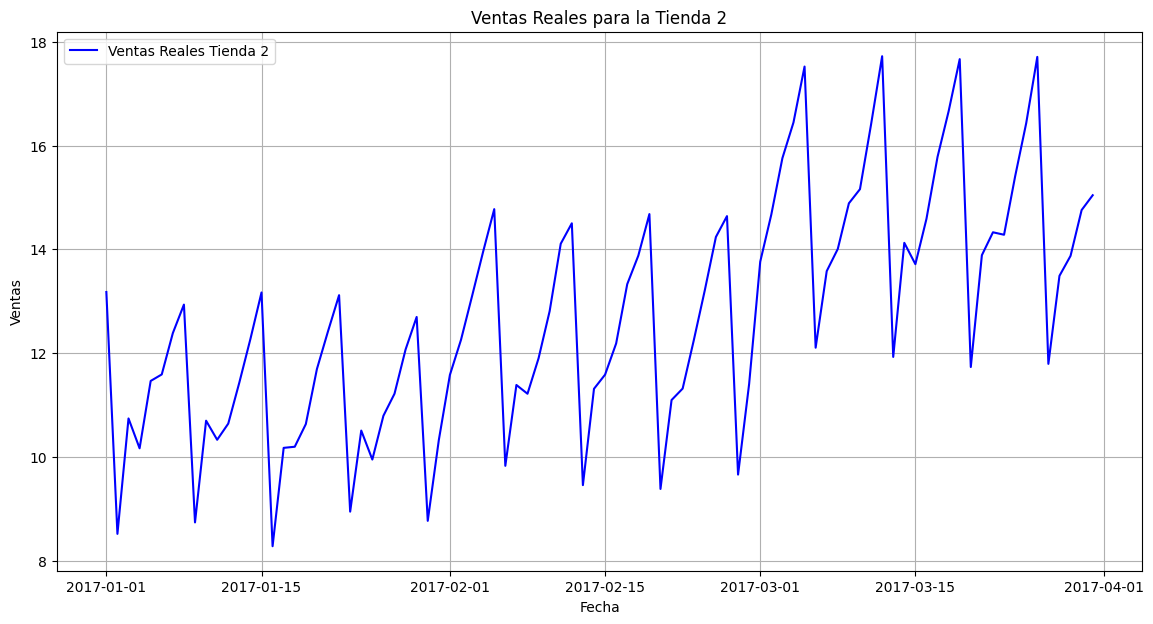


Métricas de error para la Tienda 2:
Mean Absolute Error (MAE): 12.70
Mean Squared Error (MSE): 166.56
Root Mean Squared Error (RMSE): 12.91


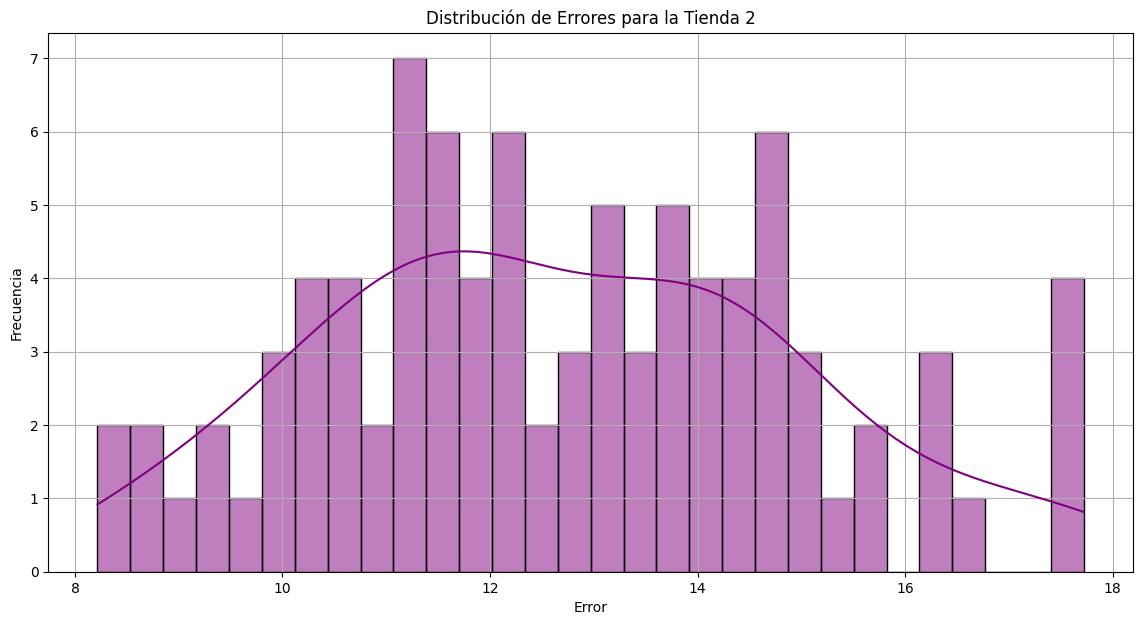

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Función para imprimir métricas y gráficos por tienda
def print_store_analysis(store_data, store):
    # Asegúrate de que 'date' sea realmente una fecha
    store_data['date'] = pd.to_datetime(store_data['date'])

    # Gráfico de ventas pronosticadas
    plt.figure(figsize=(14, 7))
    plt.plot(store_data['date'], store_data['forecasted_sales'], color='red', linestyle='--', label=f'Ventas Pronosticadas Tienda {store}')
    plt.title(f'Ventas Pronosticadas para la Tienda {store}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Si hay ventas reales disponibles en store_data, gráficarlas
    if 'sales' in store_data:
        # Gráfico de ventas reales
        plt.figure(figsize=(14, 7))
        plt.plot(store_data['date'], store_data['sales'], color='blue', label=f'Ventas Reales Tienda {store}')
        plt.title(f'Ventas Reales para la Tienda {store}')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Calcular errores si hay datos reales
        errors = store_data['sales'] - store_data['forecasted_sales']
        mae = mean_absolute_error(store_data['sales'], store_data['forecasted_sales'])
        mse = mean_squared_error(store_data['sales'], store_data['forecasted_sales'])
        rmse = np.sqrt(mse)

        # Imprimir métricas de error
        print(f"\nMétricas de error para la Tienda {store}:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

        # Gráfico de distribución de errores
        plt.figure(figsize=(14, 7))
        sns.histplot(errors, bins=30, kde=True, color='purple')
        plt.title(f'Distribución de Errores para la Tienda {store}')
        plt.xlabel('Error')
        plt.ylabel('Frecuencia')
        plt.grid(True)
        plt.show()
    else:
        print(f"\nNo hay datos de ventas reales disponibles para la Tienda {store} para el período pronosticado.")

# Asumiendo que 'merged' es tu DataFrame que contiene tanto las predicciones como las ventas reales
for store in merged['store'].unique():
    store_data = merged[merged['store'] == store].sort_values('date')
    print_store_analysis(store_data, store)


Segunda operacion

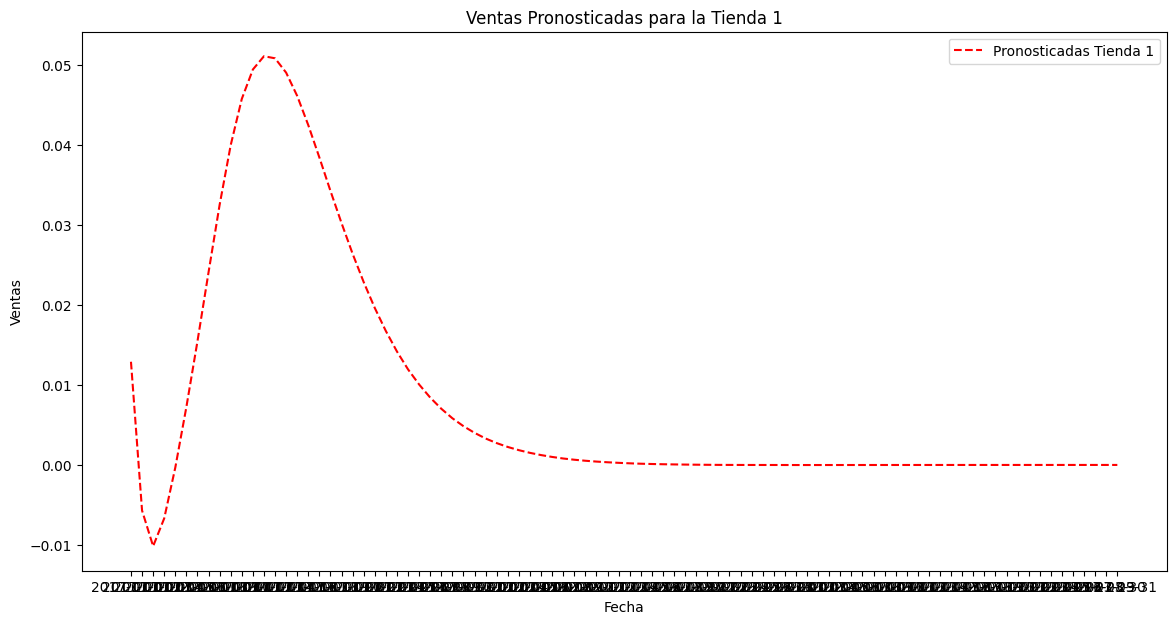

Estadísticas de ventas pronosticadas para la Tienda 1:
count    90.000000
mean      0.007953
std       0.015113
min      -0.010153
25%      -0.000003
50%       0.000076
75%       0.008120
max       0.051051
Name: forecasted_sales, dtype: float64


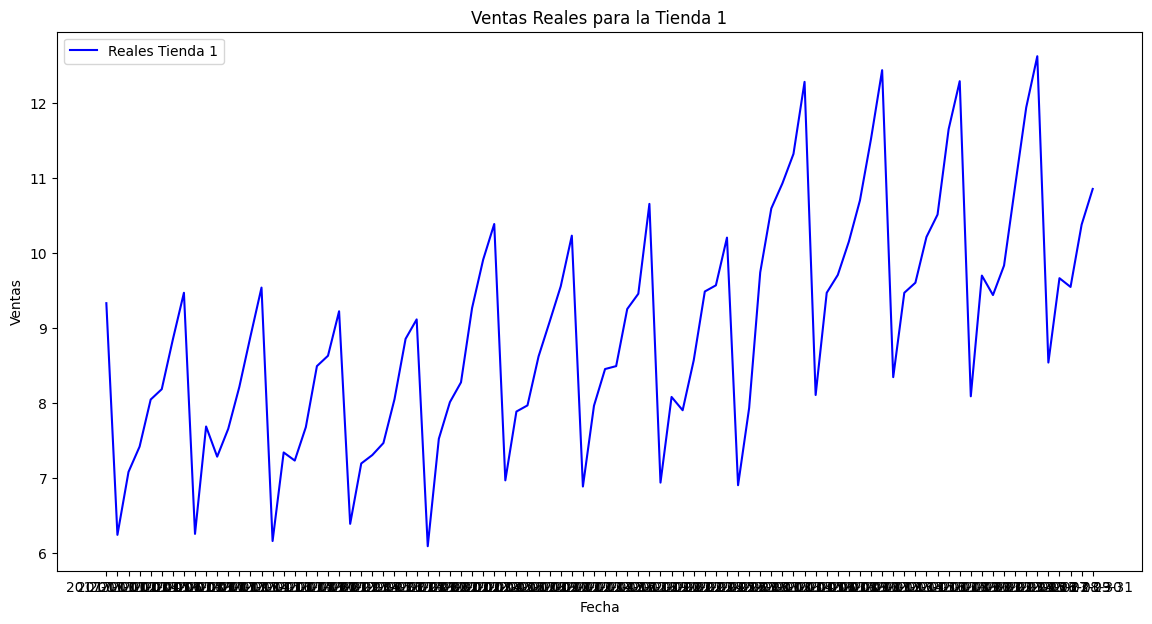

Estadísticas de ventas reales para la Tienda 1:
count    90.000000
mean      8.957239
std       1.547038
min       6.086580
25%       7.908009
50%       8.867965
75%       9.808442
max      12.623377
Name: sales, dtype: float64
Tienda 1 - MAE: 8.949285648733154, MSE: 82.47275070493782, RMSE: 9.08145091408514


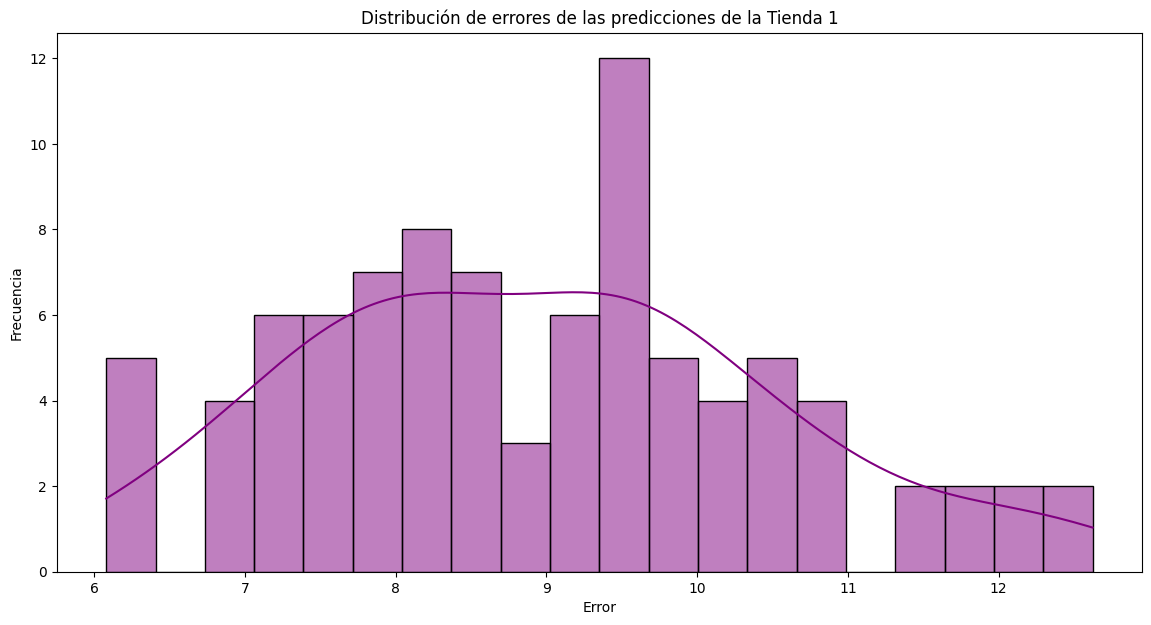

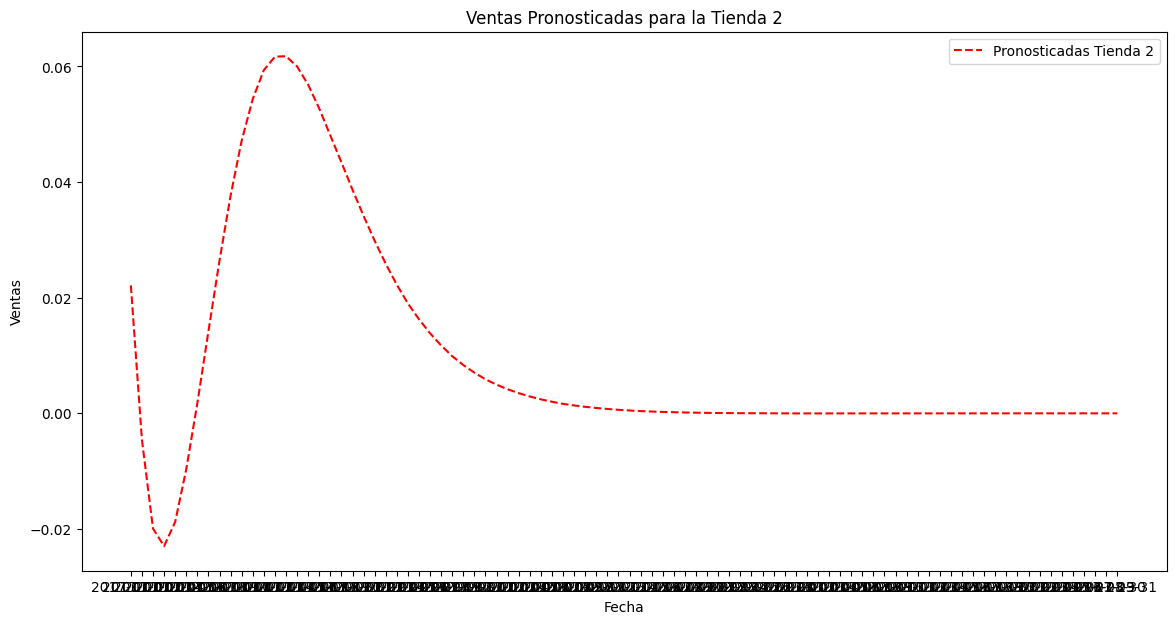

Estadísticas de ventas pronosticadas para la Tienda 2:
count    90.000000
mean      0.009364
std       0.019095
min      -0.022988
25%      -0.000003
50%       0.000172
75%       0.011270
max       0.061777
Name: forecasted_sales, dtype: float64


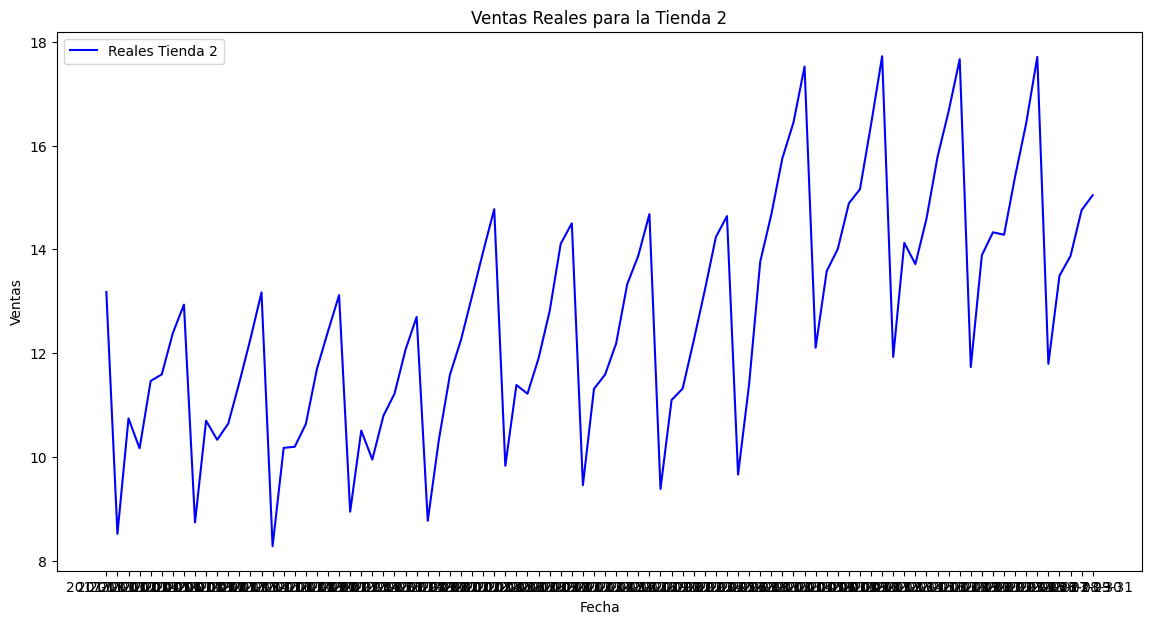

Estadísticas de ventas reales para la Tienda 2:
count    90.000000
mean     12.714238
std       2.274001
min       8.277056
25%      11.216450
50%      12.402597
75%      14.270563
max      17.722944
Name: sales, dtype: float64
Tienda 2 - MAE: 12.704873170400202, MSE: 166.55837405086024, RMSE: 12.905749650867254


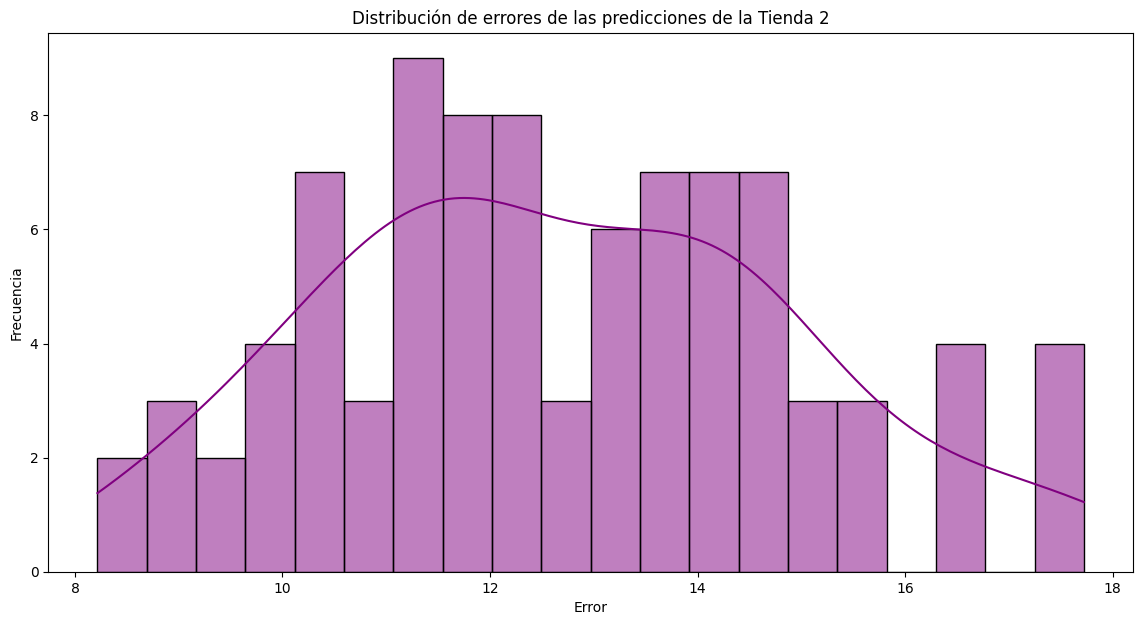

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ... [parte inicial del código se mantiene igual]

def analyze_store(store_data, store):
    # Gráfico de ventas pronosticadas
    plt.figure(figsize=(14, 7))
    plt.plot(store_data['date'], store_data['forecasted_sales'], 'r--', label=f'Pronosticadas Tienda {store}')
    plt.title(f'Ventas Pronosticadas para la Tienda {store}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    # Imprimir estadísticas resumidas de las ventas pronosticadas
    print(f"Estadísticas de ventas pronosticadas para la Tienda {store}:")
    print(store_data['forecasted_sales'].describe())

    if 'sales' in store_data:
        # Gráfico de ventas reales
        plt.figure(figsize=(14, 7))
        plt.plot(store_data['date'], store_data['sales'], 'b', label=f'Reales Tienda {store}')
        plt.title(f'Ventas Reales para la Tienda {store}')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas')
        plt.legend()
        plt.show()

        # Imprimir estadísticas resumidas de las ventas reales
        print(f"Estadísticas de ventas reales para la Tienda {store}:")
        print(store_data['sales'].describe())

        # Calcular y mostrar métricas de error
        mae = mean_absolute_error(store_data['sales'], store_data['forecasted_sales'])
        mse = mean_squared_error(store_data['sales'], store_data['forecasted_sales'])
        rmse = np.sqrt(mse)
        print(f'Tienda {store} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

        # Gráfico de errores
        errors = store_data['sales'] - store_data['forecasted_sales']
        plt.figure(figsize=(14, 7))
        sns.histplot(errors, bins=20, color='purple', kde=True)
        plt.title(f'Distribución de errores de las predicciones de la Tienda {store}')
        plt.xlabel('Error')
        plt.ylabel('Frecuencia')
        plt.show()

# Análisis por tienda
for store in merged['store'].unique():
    store_data = merged[merged['store'] == store]
    analyze_store(store_data, store)


Tercera


Estadísticas de ventas pronosticadas para la Tienda 1:
count    90.000000
mean      0.007953
std       0.015113
min      -0.010153
25%      -0.000003
50%       0.000076
75%       0.008120
max       0.051051
Name: forecasted_sales, dtype: float64


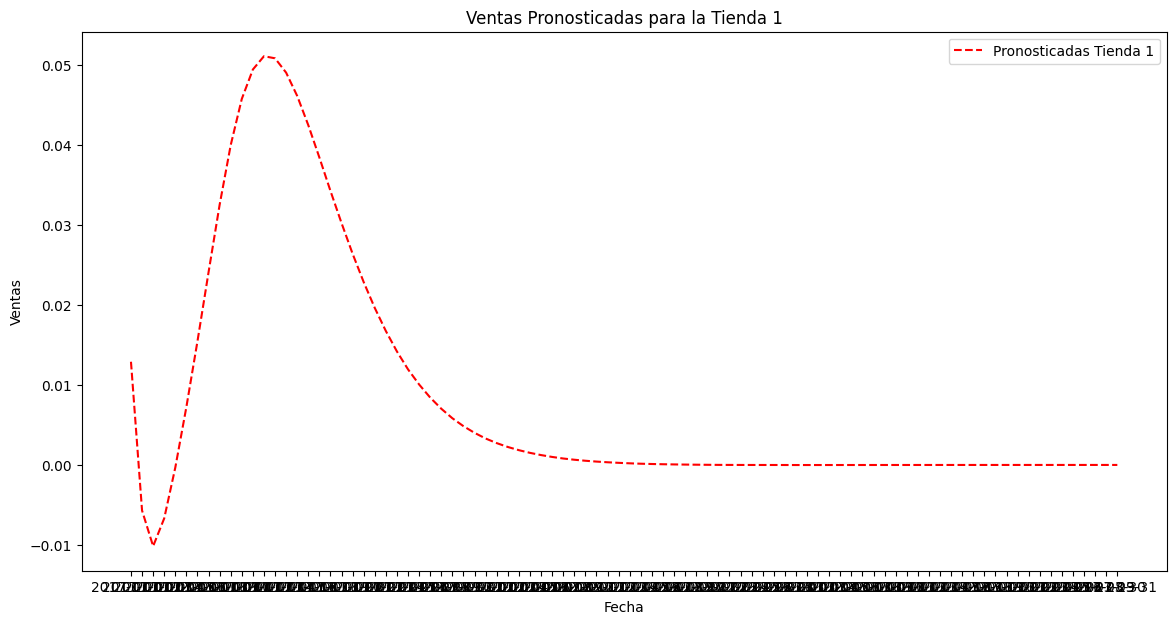


Estadísticas de ventas reales para la Tienda 1:
count    90.000000
mean      8.957239
std       1.547038
min       6.086580
25%       7.908009
50%       8.867965
75%       9.808442
max      12.623377
Name: sales, dtype: float64


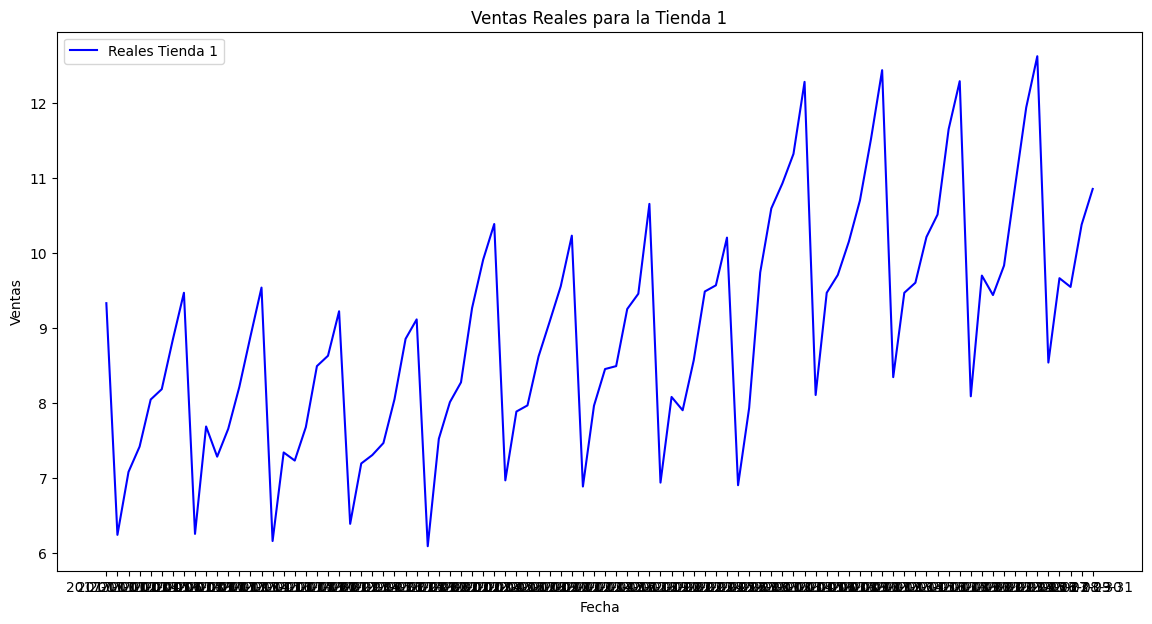


Tienda 1 - MAE: 8.949285648733154, MSE: 82.47275070493782, RMSE: 9.08145091408514


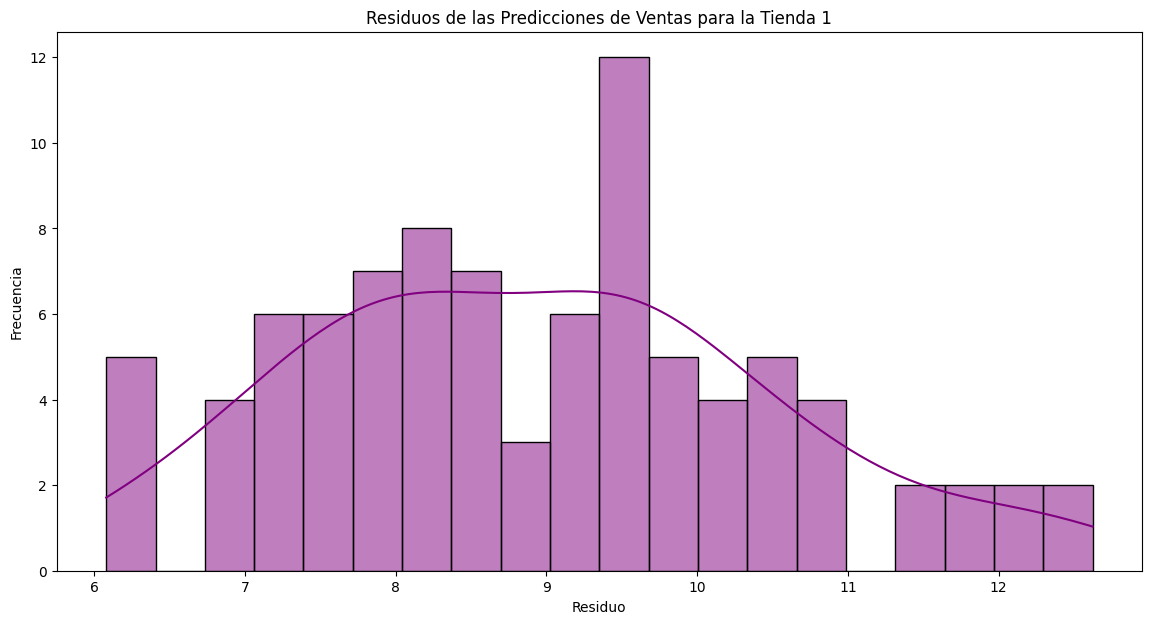

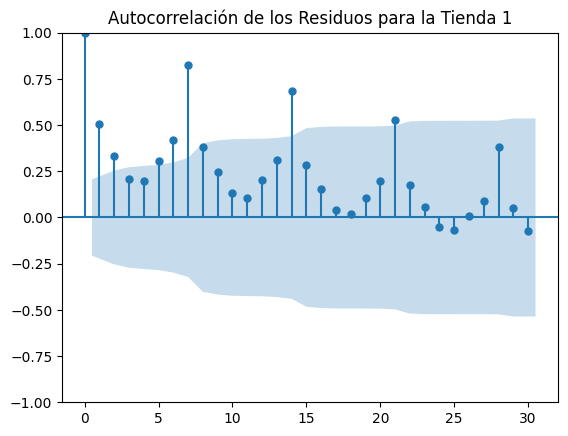

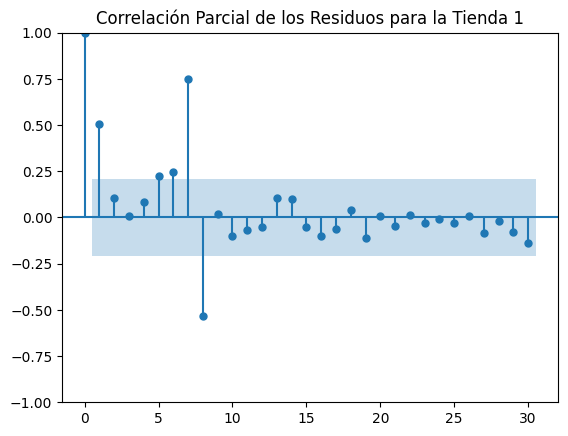


Estadísticas de ventas pronosticadas para la Tienda 2:
count    90.000000
mean      0.009364
std       0.019095
min      -0.022988
25%      -0.000003
50%       0.000172
75%       0.011270
max       0.061777
Name: forecasted_sales, dtype: float64


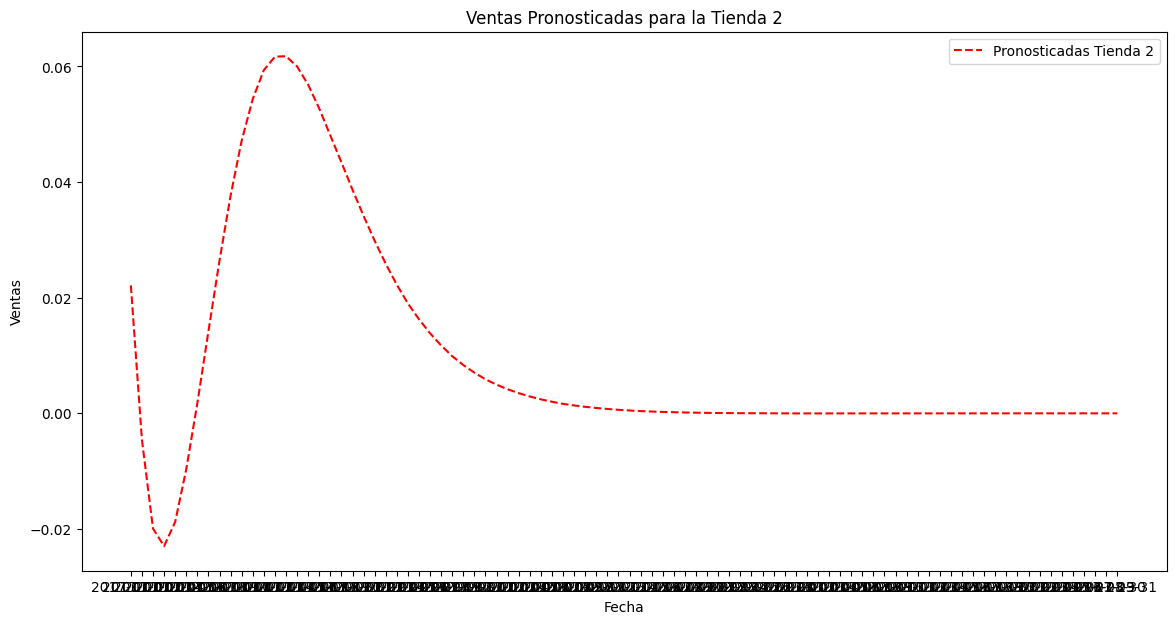


Estadísticas de ventas reales para la Tienda 2:
count    90.000000
mean     12.714238
std       2.274001
min       8.277056
25%      11.216450
50%      12.402597
75%      14.270563
max      17.722944
Name: sales, dtype: float64


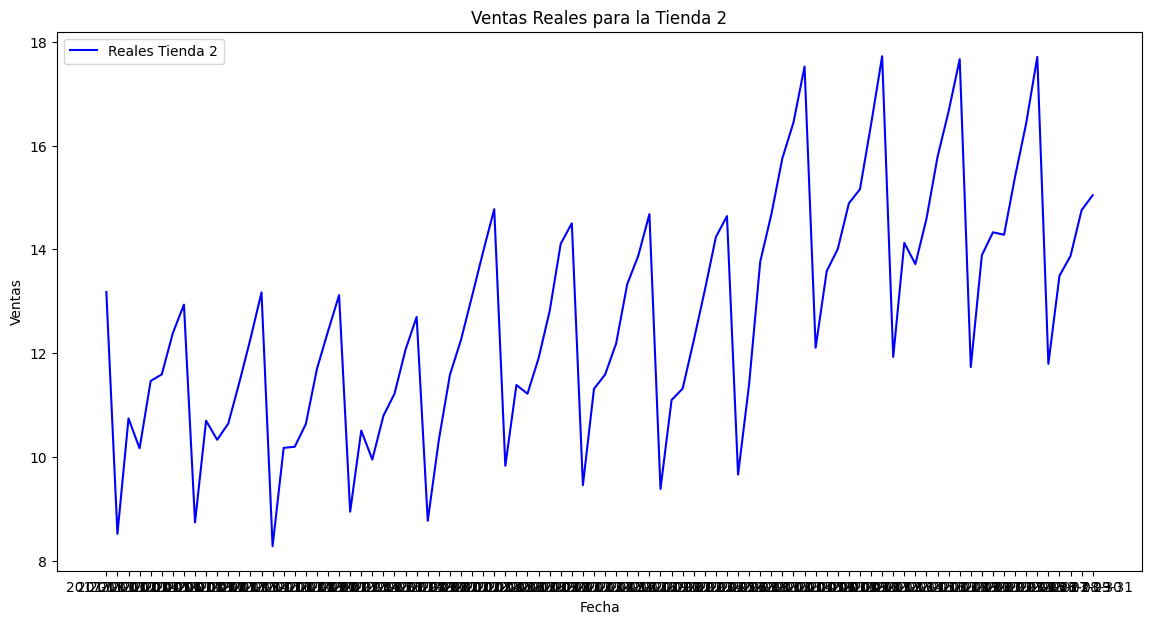


Tienda 2 - MAE: 12.704873170400202, MSE: 166.55837405086024, RMSE: 12.905749650867254


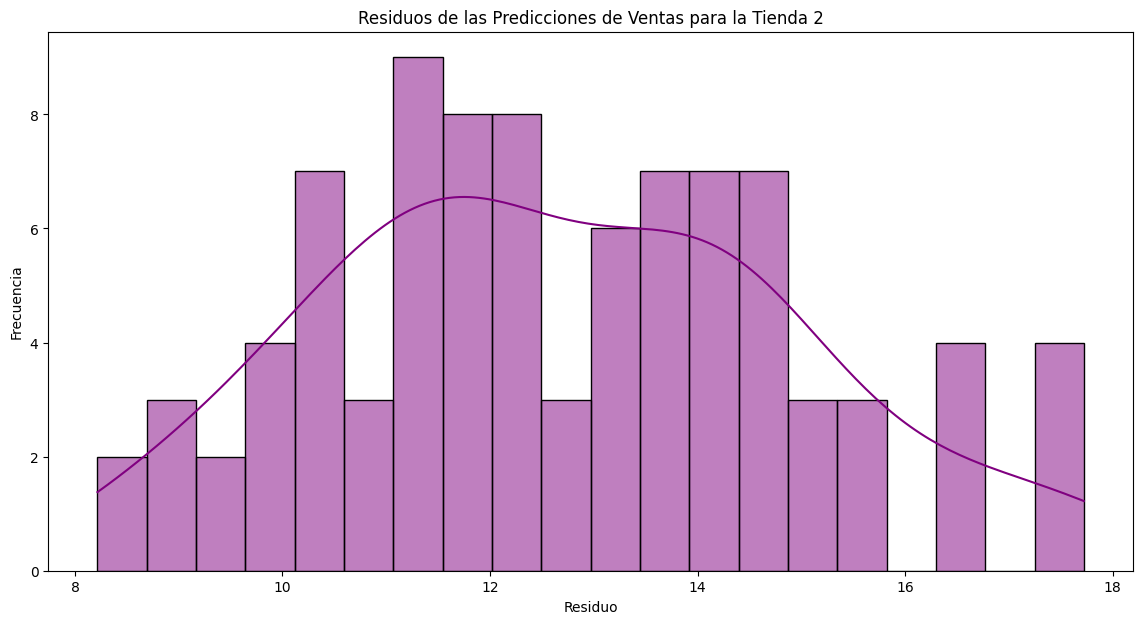

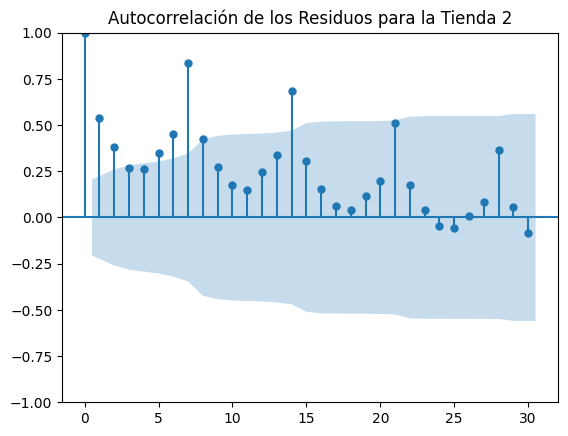

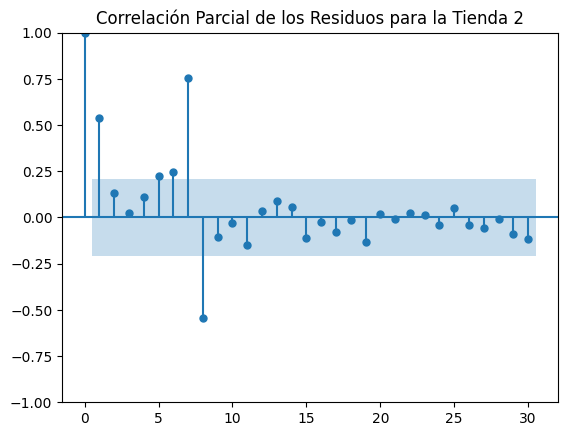

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ... [parte inicial del código se mantiene igual]

def analyze_store(store_data, store):
    # Estadísticas descriptivas de las ventas pronosticadas
    print(f"\nEstadísticas de ventas pronosticadas para la Tienda {store}:")
    print(store_data['forecasted_sales'].describe())

    # Gráfico de ventas pronosticadas
    plt.figure(figsize=(14, 7))
    plt.plot(store_data['date'], store_data['forecasted_sales'], 'r--', label=f'Pronosticadas Tienda {store}')
    plt.title(f'Ventas Pronosticadas para la Tienda {store}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.show()

    # Si hay ventas reales disponibles, hacemos análisis adicionales
    if 'sales' in store_data:
        # Estadísticas descriptivas de las ventas reales
        print(f"\nEstadísticas de ventas reales para la Tienda {store}:")
        print(store_data['sales'].describe())

        # Gráfico de ventas reales
        plt.figure(figsize=(14, 7))
        plt.plot(store_data['date'], store_data['sales'], 'b-', label=f'Reales Tienda {store}')
        plt.title(f'Ventas Reales para la Tienda {store}')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas')
        plt.legend()
        plt.show()

        # Calcular y mostrar métricas de error
        mae = mean_absolute_error(store_data['sales'], store_data['forecasted_sales'])
        mse = mean_squared_error(store_data['sales'], store_data['forecasted_sales'])
        rmse = np.sqrt(mse)
        print(f'\nTienda {store} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

        # Gráfico de residuos (errores) de las predicciones
        residuals = store_data['sales'] - store_data['forecasted_sales']
        plt.figure(figsize=(14, 7))
        sns.histplot(residuals, bins=20, color='purple', kde=True)
        plt.title(f'Residuos de las Predicciones de Ventas para la Tienda {store}')
        plt.xlabel('Residuo')
        plt.ylabel('Frecuencia')
        plt.show()

        # Gráfico de autocorrelación de los residuos para verificar la aleatoriedad
        plot_acf(residuals, lags=30, title=f'Autocorrelación de los Residuos para la Tienda {store}')
        plt.show()

        # Gráfico de correlación parcial de los residuos
        plot_pacf(residuals, lags=30, title=f'Correlación Parcial de los Residuos para la Tienda {store}')
        plt.show()

# Análisis por tienda
for store in merged['store'].unique():
    store_data = merged[merged['store'] == store]
    analyze_store(store_data, store)


Diferencia en ventas entre 2016 y 2017: 709.4935064935089


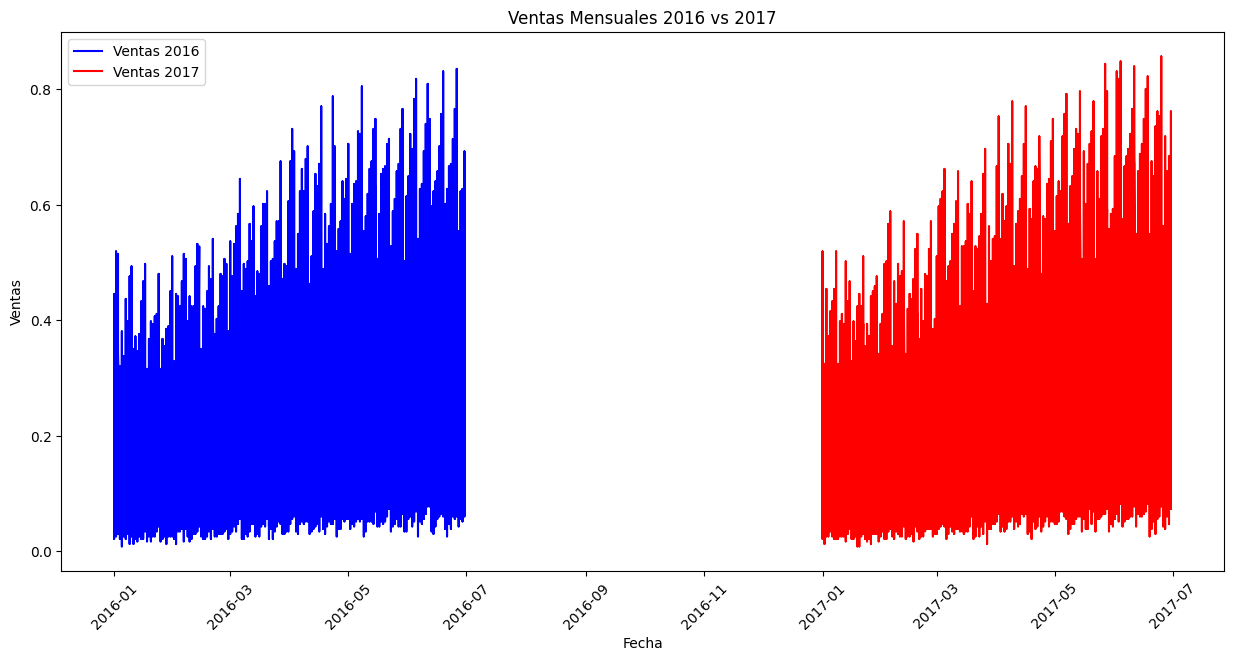

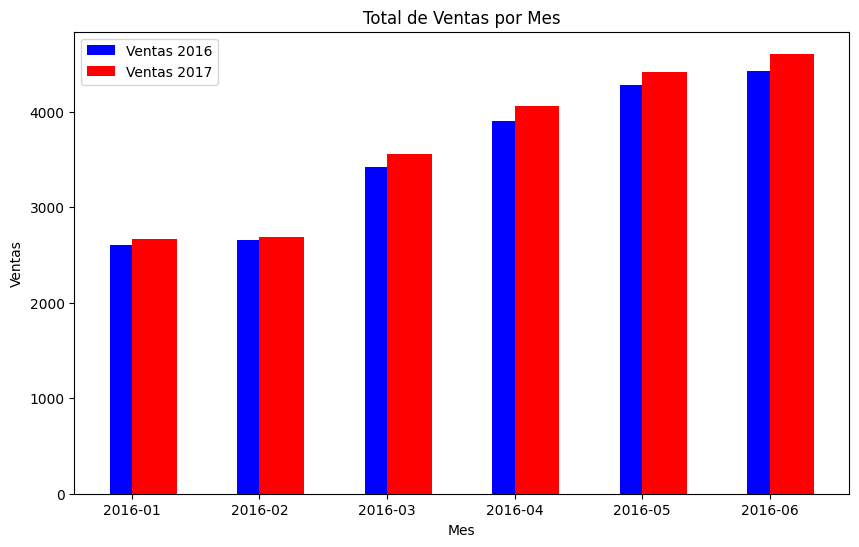

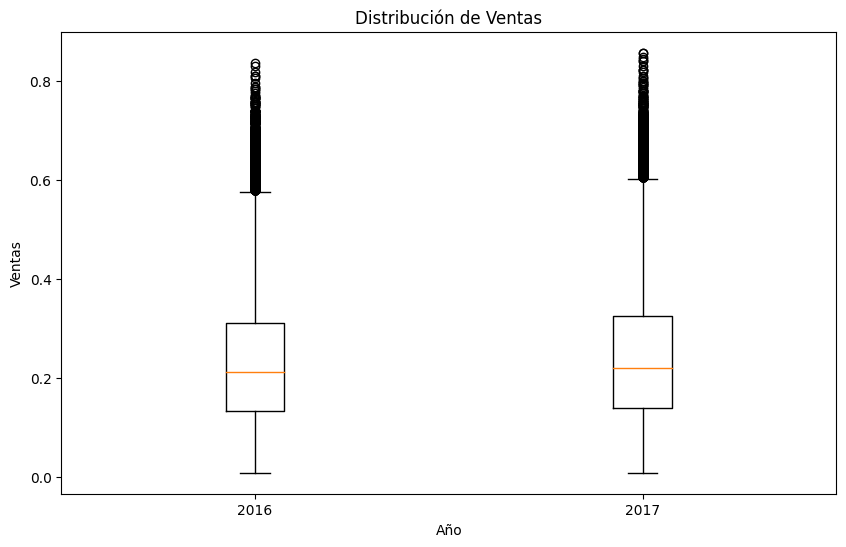

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que 'data' es tu DataFrame y ya contiene datos de ventas con fechas.
data['date'] = pd.to_datetime(data['date'])

# Filtrar los datos para los primeros 6 meses de 2016 y 2017.
data_2016 = data[(data['date'] >= '2016-01-01') & (data['date'] < '2016-07-01')]
data_2017 = data[(data['date'] >= '2017-01-01') & (data['date'] < '2017-07-01')]

# Calcular la suma total de ventas
total_sales_2016 = data_2016['sales'].sum()
total_sales_2017 = data_2017['sales'].sum()

# Calcular la diferencia
difference = total_sales_2017 - total_sales_2016
print(f'Diferencia en ventas entre 2016 y 2017: {difference}')

# Gráfico de líneas
plt.figure(figsize=(15,7))
plt.plot(data_2016['date'], data_2016['sales'], label='Ventas 2016', color='blue')
plt.plot(data_2017['date'], data_2017['sales'], label='Ventas 2017', color='red')
plt.title('Ventas Mensuales 2016 vs 2017')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras
plt.figure(figsize=(10,6))
width = 0.35  # the width of the bars
months = monthly_sales_2016.index.astype(str)
x = range(len(months))
plt.bar(x, monthly_sales_2016['sales'], width, label='Ventas 2016', color='blue', align='center')
plt.bar(x, monthly_sales_2017['sales'], width, label='Ventas 2017', color='red', align='edge')
plt.title('Total de Ventas por Mes')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.xticks(ticks=x, labels=months)
plt.legend()
plt.show()

# Gráfico de cajas
plt.figure(figsize=(10,6))
plt.boxplot([data_2016['sales'], data_2017['sales']], labels=['2016', '2017'])
plt.title('Distribución de Ventas')
plt.xlabel('Año')
plt.ylabel('Ventas')
plt.show()


Ventas totales en los primeros 6 meses de 2016: 21305.71861471861
Ventas totales en los primeros 6 meses de 2017: 22015.21212121212
Diferencia en ventas entre 2016 y 2017: 709.4935064935089


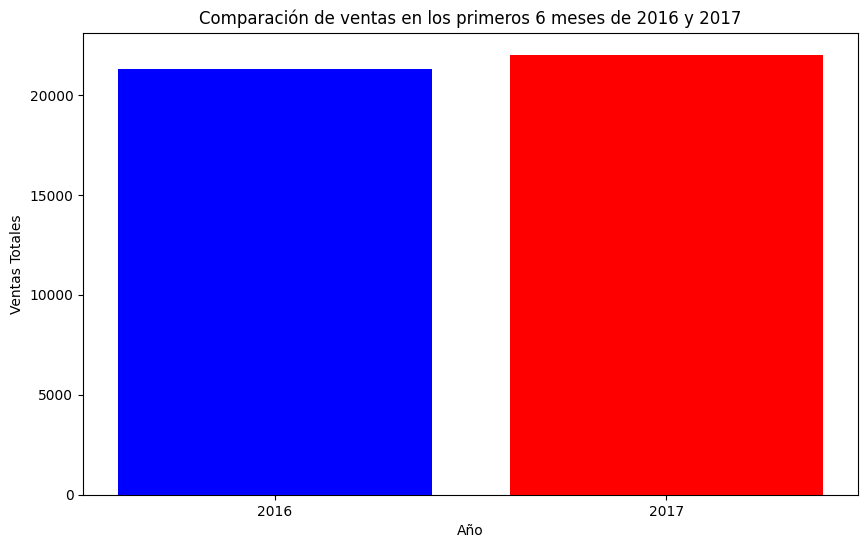

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que 'data' es tu DataFrame y ya contiene datos de ventas con fechas.
data['date'] = pd.to_datetime(data['date'])

# Filtrar los datos para los primeros 6 meses de 2016 y 2017.
data_2016 = data[(data['date'] >= '2016-01-01') & (data['date'] < '2016-07-01')]
data_2017 = data[(data['date'] >= '2017-01-01') & (data['date'] < '2017-07-01')]

# Calcular la suma total de ventas
total_sales_2016 = data_2016['sales'].sum()
total_sales_2017 = data_2017['sales'].sum()

# Calcular la diferencia
difference = total_sales_2017 - total_sales_2016
print(f'Ventas totales en los primeros 6 meses de 2016: {total_sales_2016}')
print(f'Ventas totales en los primeros 6 meses de 2017: {total_sales_2017}')
print(f'Diferencia en ventas entre 2016 y 2017: {difference}')

# Gráfico comparativo
plt.figure(figsize=(10,6))
years = ['2016', '2017']
sales = [total_sales_2016, total_sales_2017]

plt.bar(years, sales, color=['blue', 'red'])
plt.title('Comparación de ventas en los primeros 6 meses de 2016 y 2017')
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.show()


10. Interpretabilidad

El modelo trabajado funciona para predecir las ventas en un periodo de 3 meses. Los últimos gráficos generados en el punto 9 son una herramienta para visualizar si el modelo funcionó según lo esperado. En estos gráficos se reflejan las ventas reales para los años 2016 y 2017 los cuales fueron los evaluados durante el laboratorio.

Para los primeros 3 meses de 2017 se ve que enero y febrero tienen el comportamiento esperado ya que las ventas aumentan de mes a mes, sin embargo, para mediados de marzo y el resto del semestre las ventas caen. En los gráficos del punto 9 se ve que estos no eran los resultados esperados ya que las ventas aumentaron pero no lo hicieron tanto, siguieron un crecimiento controlado. Sin embargo, para mediados de febrero es posible observar que existe una pequeña caida en las ventas, es posible que el modelo interpretara esta caida como un comportamiento que continuaría por lo que la tendencia quedó marcada y se arregló pero no lo suficiente como para corregir la tendencia esperada.

Se realizaron 3 iteraciones para este modelo y no existieron mayores diferencias entre ellas. Ambas tiendas reflejaron un comporamiento similar durante los 3 primeros meses de 2017, tomando como referencia lo ocurrido en el mismo periodo de 2016.

In [47]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.6 MB/s eta 0:00:00


In [50]:
print(X_train.shape)

(437952, 60, 1)


In [51]:
# Aplanar la dimensión de los pasos temporales
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Esto convertirá la forma a (437952, 60)

print(X_train_flat.shape)


(437952, 60)


[17:25:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


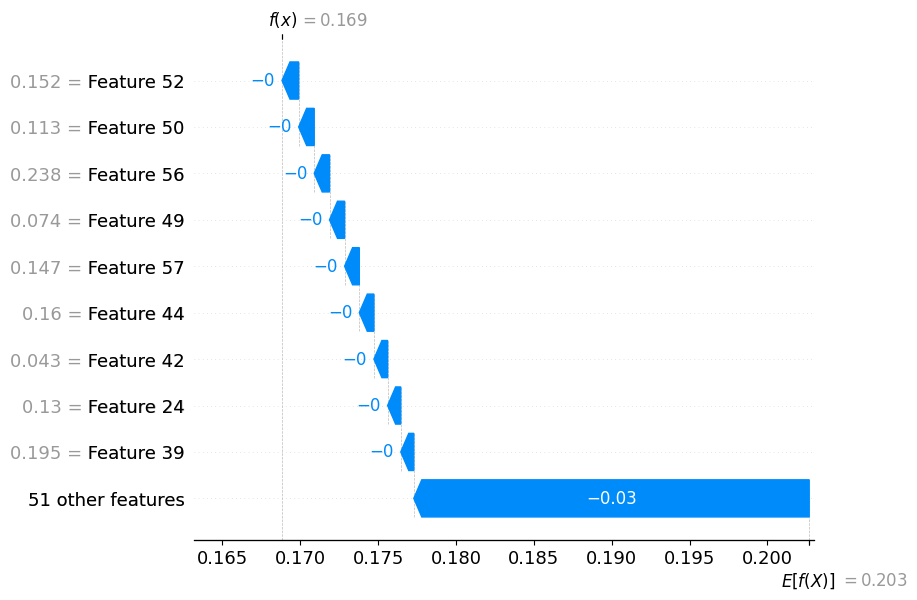

IndexError: ignored

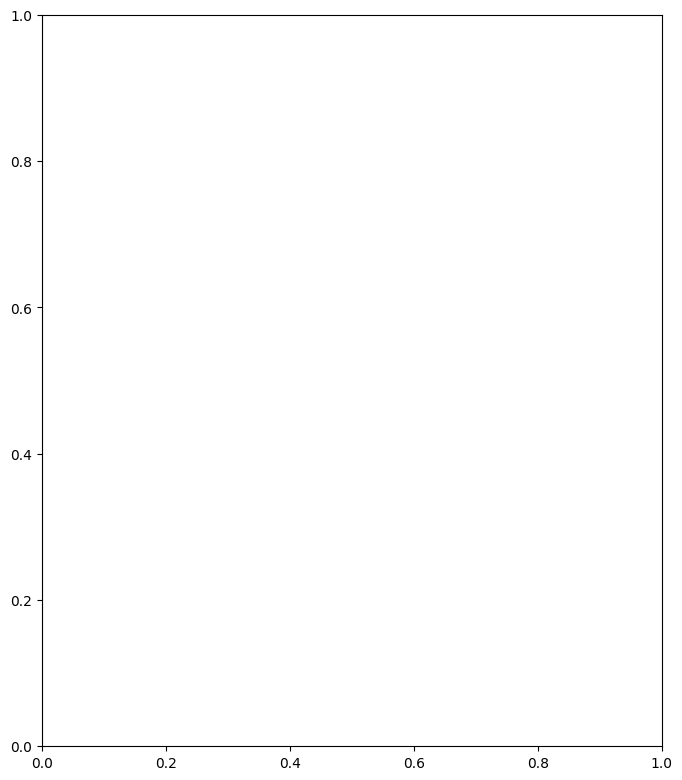

In [55]:
import shap
import xgboost
import numpy as np

# Aplanar la última dimensión si es 1
if X_train_np.shape[-1] == 1:
    X_train_2d = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1]))
else:
    # En caso de que la última dimensión no sea 1, debes decidir cómo manejar este caso.
    # Una opción es simplemente aplanar las últimas dos dimensiones.
    X_train_2d = X_train_np.reshape((X_train_np.shape[0], -1))  # Esto combina las últimas dos dimensiones

# Continuar con el entrenamiento del modelo como antes, pero usando X_train_2d
dtrain = xgboost.DMatrix(X_train_2d, label=y_train)

# Entrenar el modelo; los parámetros pueden necesitar ser ajustados dependiendo de tu problema específico
params = {"learning_rate": 0.01, "objective": "reg:squarederror"}  # Aquí, 'reg:squarederror' es un objetivo común para la regresión; cámbialo según sea necesario
num_round = 100  # Número de rondas de entrenamiento; ajústalo según sea necesario
model = xgboost.train(params, dtrain, num_round)

# Explicar las predicciones del modelo utilizando SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train_2d)  # Usa los datos aplanados aquí, ya que SHAP trabaja con ndarrays

# Visualizar la primera predicción; esto mostrará la contribución de cada característica en la primera predicción del conjunto de entrenamiento
shap.plots.waterfall(shap_values[0])

# Si quieres una vista general de las características importantes para todo el conjunto de datos, puedes usar summary_plot
shap.summary_plot(shap_values, X_train)

